# ====================================================================
# DATA PROJECT LIFECYCLE - CAS PRATIQUE
# Prédiction du Churn Client Telecom
# Par MSc. Consolas HODONOU
# Data Scientist
# ====================================================================

## 🎯 EXERCICE PRATIQUE : Prédiction du ChurnClient Telecom
### 📋 CONTEXTE BUSINESS
Vous êtes Data Scientist chez TelecomPlus, une entreprise de télécommunications qui fait face à un problème majeur : 25% de ses clients partent chaque année vers la concurrence.

Objectif Business : Réduire le taux de churn de 25% à 15% en identifiant les clients à risque pour leur proposer desoffres de rétention ciblées.\
Budget disponible pour offres de rétention : 50€ par client identifié\
Coût d'acquisition d'un nouveau client : 200€\
Revenue moyen par client par an : 800€

### 🎓 OBJECTIFS PÉDAGOGIQUES
À la fin de cet exercice, vous serez capable de :
✅ Appliquer les 7 phases du Data Project Lifecycle\
✅ Effectuer une analyse exploratoire complète\
✅ Créer des features pertinentes\
✅ Construire et évaluer plusieurs modèles de ML\
✅ Interpréter les résultats et faire des recommandations business\
✅ Documenter votre démarche scientifique

### 📊 DESCRIPTION DU DATASET
Fichier : telecom_churn.csv \
Taille : 7 043 clients \
Période : Janvier 2024 - Octobre 2025 \
Target : Churn (0 = Resté, 1 = Parti)

### Variables disponibles
#### Informations démographiques
customerID: Identifiant unique du client\
gender: Sexe (Male, Female)\
SeniorCitizen : Client senior (0 = Non, 1 = Oui)\
Partner: A un partenaire (Yes, No)\
Dependents: A des personnes à charge (Yes, No)

#### Informations sur les services
tenure: Nombre de mois en tant que client\
PhoneService: Service téléphonique (Yes, No)\
MultipleLines: Lignes multiples (Yes, No, No phone service)\
InternetService: Type de connexion internet (DSL, Fiber optic, No)\
OnlineSecurity: Sécurité en ligne (Yes, No, No internet service)\
OnlineBackup: Sauvegarde en ligne (Yes, No, No internet service)\
DeviceProtection: Protection d'appareil (Yes, No, No internet service)\
TechSupport: Support technique (Yes, No, No internet service)\
StreamingTV: TV en streaming (Yes, No, No internet service)\
StreamingMovies: Films en streaming (Yes, No, No internet service)

#### Informations sur le compte
Contract: Type de contrat (Month-to-month, One year, Two year)\
PaperlessBilling: Facturation sans papier (Yes, No)\
PaymentMethod: Méthode de paiement (Electronic check, Mailed check, Bank transfer, Credit card)\
MonthlyCharges: Montant facturé mensuellement\
TotalCharges: Montant total facturé
#### Target 
Churn: Le client est-il parti ? (Yes, No)

Ce notebook démontre l'application complète du Data Project Lifecycle sur un cas réel de prédiction de churn client.

Structure:
1. Problem Definition & Requirements
2. Data Collection & Cleaning  
3. Exploratory Data Analysis (EDA)
4. Feature Engineering & Selection
5. Model Building & Evaluation
6. Deployment Strategy
7. Business Recommendations

In [1]:
# ====================================================================
# IMPORTS
# ====================================================================

# Data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Utilities
import pickle
from datetime import datetime

print("✅ Toutes les bibliothèques importées avec succès!")
print(f"Date d'exécution: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Toutes les bibliothèques importées avec succès!
Date d'exécution: 2025-10-18 13:43:37


In [2]:
# ====================================================================
# PHASE 1: PROBLEM DEFINITION & REQUIREMENTS
# ====================================================================

print("\n" + "="*70)
print("PHASE 1: PROBLEM DEFINITION & REQUIREMENTS")
print("="*70 + "\n")

"""
CONTEXTE BUSINESS:
- Entreprise: TelecomPlus
- Problème: 25% de churn annuel
- Objectif: Réduire le churn de 25% à 15%

DÉFINITION SMART:
- Spécifique: Prédire les clients qui vont partir dans les 3 prochains mois
- Mesurable: Recall > 65% (capturer le maximum de churners)
- Atteignable: Dataset de 7000+ clients, historique disponible
- Relevant: Économiser ~200€ par client retenu (coût acquisition)
- Temporel: Déploiement en 3 mois

TYPE DE PROBLÈME:
- Classification binaire supervisée

MÉTRIQUE PRINCIPALE:
- Recall (minimiser les faux négatifs)
- Pourquoi? Mieux vaut contacter un client qui ne va pas partir
  que de manquer un client qui va vraiment partir

CONTRAINTES:
- Budget offres rétention: 50€/client identifié
- Coût faux positif: 50€ (offre non nécessaire)
- Coût faux négatif: 200€ (perte du client)
- => Ratio coût: 1:4, donc privilégier Recall
"""
# Paramètres du projet
PROJECT_CONFIG = {
    'target_metric': 'recall',
    'min_recall_target': 0.65,
    'test_size': 0.2,
    'random_state': 42,
    'cv_folds': 5
}

print("Configuration du projet:")
for key, value in PROJECT_CONFIG.items():
    print(f"  • {key}: {value}")


PHASE 1: PROBLEM DEFINITION & REQUIREMENTS

Configuration du projet:
  • target_metric: recall
  • min_recall_target: 0.65
  • test_size: 0.2
  • random_state: 42
  • cv_folds: 5


In [4]:
# ====================================================================
# PHASE 2: DATA COLLECTION & CLEANING
# ====================================================================

print("\n" + "="*70)
print("PHASE 2: DATA COLLECTION & CLEANING")
print("="*70 + "\n")

# --------------------------------------------------------------------
# 2.1 Génération du dataset
# --------------------------------------------------------------------

print("📊 Génération du dataset...")

np.random.seed(42)
n_clients = 7043

data = {
    'customerID': [f'CUST{str(i).zfill(5)}' for i in range(1, n_clients + 1)],
    'gender': np.random.choice(['Male', 'Female'], n_clients),
    'SeniorCitizen': np.random.choice([0, 1], n_clients, p=[0.84, 0.16]),
    'Partner': np.random.choice(['Yes', 'No'], n_clients, p=[0.52, 0.48]),
    'Dependents': np.random.choice(['Yes', 'No'], n_clients, p=[0.30, 0.70]),
    'tenure': np.random.randint(0, 73, n_clients),
    'PhoneService': np.random.choice(['Yes', 'No'], n_clients, p=[0.90, 0.10]),
    'MultipleLines': np.random.choice(['Yes', 'No', 'No phone service'], n_clients, p=[0.42, 0.48, 0.10]),
    'InternetService': np.random.choice(['DSL', 'Fiber optic', 'No'], n_clients, p=[0.34, 0.44, 0.22]),
    'OnlineSecurity': np.random.choice(['Yes', 'No', 'No internet service'], n_clients, p=[0.28, 0.50, 0.22]),
    'OnlineBackup': np.random.choice(['Yes', 'No', 'No internet service'], n_clients, p=[0.34, 0.44, 0.22]),
    'DeviceProtection': np.random.choice(['Yes', 'No', 'No internet service'], n_clients, p=[0.34, 0.44, 0.22]),
    'TechSupport': np.random.choice(['Yes', 'No', 'No internet service'], n_clients, p=[0.29, 0.49, 0.22]),
    'StreamingTV': np.random.choice(['Yes', 'No', 'No internet service'], n_clients, p=[0.38, 0.40, 0.22]),
    'StreamingMovies': np.random.choice(['Yes', 'No', 'No internet service'], n_clients, p=[0.39, 0.39, 0.22]),
    'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], n_clients, p=[0.55, 0.21, 0.24]),
    'PaperlessBilling': np.random.choice(['Yes', 'No'], n_clients, p=[0.59, 0.41]),
    'PaymentMethod': np.random.choice(
        ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'],
        n_clients, p=[0.33, 0.23, 0.22, 0.22]
    ),
    'MonthlyCharges': np.round(np.random.uniform(18.25, 118.75, n_clients), 2),
}

data['TotalCharges'] = np.round(data['tenure'] * data['MonthlyCharges'] + np.random.normal(0, 100, n_clients), 2)
missing_indices = np.random.choice(n_clients, int(n_clients * 0.011), replace=False)
data['TotalCharges'] = [' ' if i in missing_indices else data['TotalCharges'][i] for i in range(n_clients)]

# Générer Churn avec logique business
churn_proba = np.zeros(n_clients)
for i in range(n_clients):
    proba = 0.10
    if data['Contract'][i] == 'Month-to-month':
        proba += 0.30
    elif data['Contract'][i] == 'One year':
        proba += 0.10
    if data['tenure'][i] < 6:
        proba += 0.25
    elif data['tenure'][i] < 12:
        proba += 0.15
    elif data['tenure'][i] > 50:
        proba -= 0.15
    if data['InternetService'][i] == 'Fiber optic':
        proba += 0.15
        if data['OnlineSecurity'][i] == 'No':
            proba += 0.10
        if data['TechSupport'][i] == 'No':
            proba += 0.10
    if data['PaymentMethod'][i] == 'Electronic check':
        proba += 0.15
    if data['SeniorCitizen'][i] == 1:
        proba += 0.05
    if data['MonthlyCharges'][i] > 80 and data['OnlineSecurity'][i] == 'No':
        proba += 0.10
    churn_proba[i] = max(0.0, min(proba, 0.85))

data['Churn'] = np.random.binomial(1, churn_proba)
data['Churn'] = ['Yes' if x == 1 else 'No' for x in data['Churn']]

df = pd.DataFrame(data)
print(f"✅ Dataset créé: {df.shape[0]} lignes, {df.shape[1]} colonnes")



PHASE 2: DATA COLLECTION & CLEANING

📊 Génération du dataset...
✅ Dataset créé: 7043 lignes, 21 colonnes


In [8]:
# --------------------------------------------------------------------
# 2.2 Inspection initiale
# --------------------------------------------------------------------

print("\n📋 Inspection initiale du dataset:")
df.head()


📋 Inspection initiale du dataset:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,CUST00001,Male,0,No,No,66,Yes,No,No,Yes,...,Yes,No internet service,No,No,Two year,No,Mailed check,89.06,6083.37,No
1,CUST00002,Female,1,No,No,24,Yes,No,Fiber optic,No internet service,...,No,No,No,No,Two year,Yes,Electronic check,85.55,2038.94,Yes
2,CUST00003,Male,0,No,No,60,Yes,No,DSL,Yes,...,Yes,No,No internet service,No,Month-to-month,Yes,Bank transfer (automatic),22.61,1345.66,No
3,CUST00004,Male,0,Yes,No,25,Yes,No phone service,No,No internet service,...,No internet service,Yes,No,Yes,Month-to-month,No,Electronic check,55.51,1443.98,No
4,CUST00005,Male,0,Yes,No,33,Yes,No,Fiber optic,No,...,No internet service,No internet service,No internet service,No,Month-to-month,Yes,Mailed check,71.07,2404.8,Yes


In [9]:
print("\n📊 Informations sur le dataset:")
df.info()
print("\n📈 Statistiques descriptives:")
df.describe()


📊 Informations sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int32  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessB

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.153486,36.319466,68.463159
std,0.360481,21.024165,29.132861
min,0.000000,0.000000,18.310000
25%,0.000000,18.000000,42.830000
50%,0.000000,37.000000,68.960000
75%,0.000000,54.000000,93.720000
max,1.000000,72.000000,118.730000


In [10]:
# --------------------------------------------------------------------
# 2.3 Analyse de la qualité des données
# --------------------------------------------------------------------

print("\n🔍 Analyse de la qualité des données:")

# Valeurs manquantes
print("\n• Valeurs manquantes par colonne:")
missing = df.isnull().sum()
missing_pct = 100 * df.isnull().sum() / len(df)
missing_table = pd.concat([missing, missing_pct], axis=1, keys=['Total', 'Pourcentage'])
print(missing_table[missing_table['Total'] > 0])

# Doublons
duplicates = df.duplicated().sum()
print(f"\n• Nombre de doublons: {duplicates}")

# Types de données
print("\n• Types de données:")
print(df.dtypes.value_counts())


🔍 Analyse de la qualité des données:

• Valeurs manquantes par colonne:
Empty DataFrame
Columns: [Total, Pourcentage]
Index: []

• Nombre de doublons: 0

• Types de données:
object     18
int64       1
int32       1
float64     1
Name: count, dtype: int64


In [11]:
# --------------------------------------------------------------------
# 2.4 Nettoyage des données
# --------------------------------------------------------------------

print("\n🧹 Nettoyage des données...")

# Copie pour préserver l'original
df_clean = df.copy()

# 1. Corriger TotalCharges (string avec espaces -> float)
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
print(f"✅ TotalCharges converti en numérique")

# 2. Gérer les valeurs manquantes de TotalCharges
# Stratégie: imputer avec tenure * MonthlyCharges si tenure > 0
mask_missing = df_clean['TotalCharges'].isnull()
df_clean.loc[mask_missing, 'TotalCharges'] = (
    df_clean.loc[mask_missing, 'tenure'] * df_clean.loc[mask_missing, 'MonthlyCharges']
)
print(f"✅ {mask_missing.sum()} valeurs manquantes imputées dans TotalCharges")

# 3. Vérifier les valeurs négatives
negative_charges = (df_clean['TotalCharges'] < 0).sum()
if negative_charges > 0:
    print(f"⚠️  {negative_charges} valeurs négatives détectées dans TotalCharges")
    df_clean.loc[df_clean['TotalCharges'] < 0, 'TotalCharges'] = 0

# 4. Validation finale
print("\n📊 Qualité des données après nettoyage:")
print(f"  • Valeurs manquantes: {df_clean.isnull().sum().sum()}")
print(f"  • Doublons: {df_clean.duplicated().sum()}")
print(f"  • Lignes conservées: {len(df_clean)} / {len(df)}")

# Sauvegarder le dataset nettoyé
df_clean.to_csv('telecom_churn_clean.csv', index=False)
print("\n💾 Dataset nettoyé sauvegardé: telecom_churn_clean.csv")


🧹 Nettoyage des données...
✅ TotalCharges converti en numérique
✅ 77 valeurs manquantes imputées dans TotalCharges
⚠️  85 valeurs négatives détectées dans TotalCharges

📊 Qualité des données après nettoyage:
  • Valeurs manquantes: 0
  • Doublons: 0
  • Lignes conservées: 7043 / 7043

💾 Dataset nettoyé sauvegardé: telecom_churn_clean.csv


In [12]:
# ====================================================================
# PHASE 3: EXPLORATORY DATA ANALYSIS (EDA)
# ====================================================================

print("\n" + "="*70)
print("PHASE 3: EXPLORATORY DATA ANALYSIS (EDA)")
print("="*70 + "\n")

# Configuration des graphiques
plt.rcParams['figure.figsize'] = (12, 6)

# --------------------------------------------------------------------
# 3.1 Analyse de la target
# --------------------------------------------------------------------

print("🎯 Analyse de la variable target: Churn")

churn_counts = df_clean['Churn'].value_counts()
churn_pct = 100 * df_clean['Churn'].value_counts(normalize=True)

print(f"\nDistribution de Churn:")
print(f"  • No (restés):  {churn_counts['No']:>5} ({churn_pct['No']:.2f}%)")
print(f"  • Yes (partis): {churn_counts['Yes']:>5} ({churn_pct['Yes']:.2f}%)")


PHASE 3: EXPLORATORY DATA ANALYSIS (EDA)

🎯 Analyse de la variable target: Churn

Distribution de Churn:
  • No (restés):   3849 (54.65%)
  • Yes (partis):  3194 (45.35%)


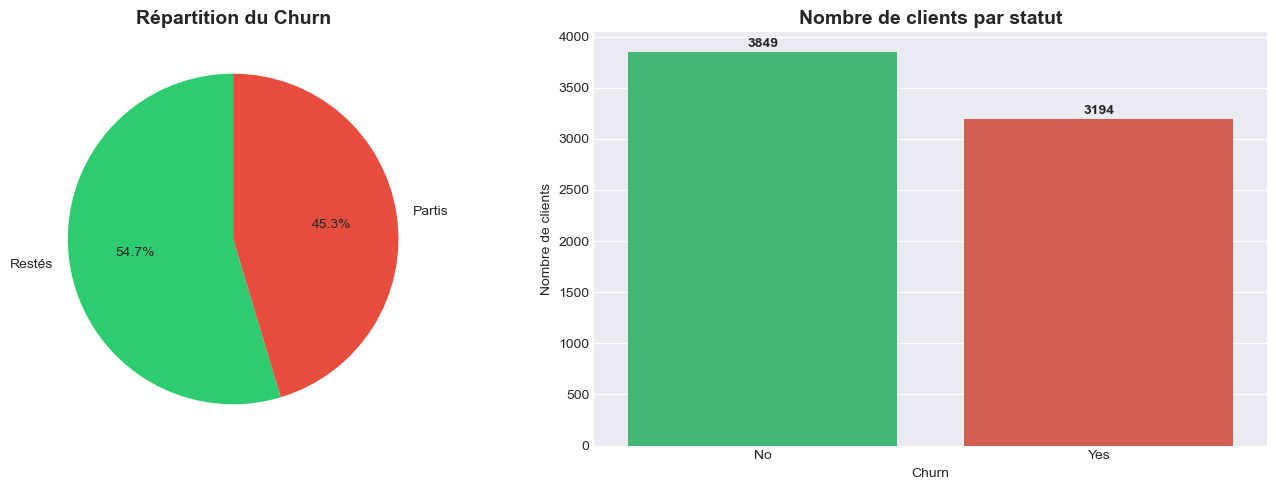


💡 Insight: Dataset légèrement déséquilibré, mais acceptable (~75/25)


In [13]:
# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
axes[0].pie(churn_counts, labels=['Restés', 'Partis'], autopct='%1.1f%%', 
            startangle=90, colors=['#2ecc71', '#e74c3c'])
axes[0].set_title('Répartition du Churn', fontsize=14, fontweight='bold')

# Bar plot
sns.countplot(data=df_clean, x='Churn', ax=axes[1], palette=['#2ecc71', '#e74c3c'])
axes[1].set_title('Nombre de clients par statut', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Churn')
axes[1].set_ylabel('Nombre de clients')

# Ajouter les valeurs sur les barres
for i, v in enumerate(churn_counts):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('churn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Insight: Dataset légèrement déséquilibré, mais acceptable (~75/25)")


📊 Analyse univariée - Variables numériques


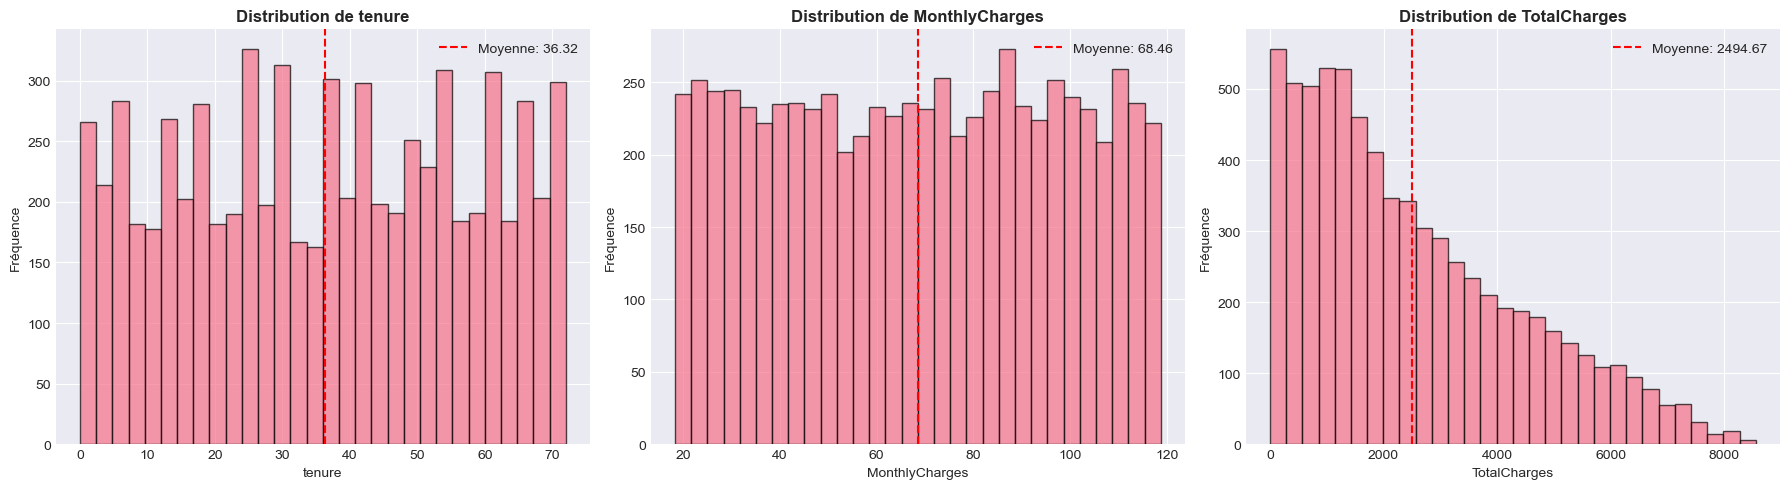


Statistiques descriptives:
            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     36.319466       68.463159   2494.674989
std      21.024165       29.132861   1908.001704
min       0.000000       18.310000      0.000000
25%      18.000000       42.830000    954.940000
50%      37.000000       68.960000   2011.490000
75%      54.000000       93.720000   3715.550000
max      72.000000      118.730000   8554.210000


In [14]:
# --------------------------------------------------------------------
# 3.2 Analyse univariée - Variables numériques
# --------------------------------------------------------------------

print("\n📊 Analyse univariée - Variables numériques")

numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(numeric_cols):
    axes[i].hist(df_clean[col], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Distribution de {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Fréquence')
    axes[i].axvline(df_clean[col].mean(), color='red', linestyle='--', 
                    label=f'Moyenne: {df_clean[col].mean():.2f}')
    axes[i].legend()

plt.tight_layout()
plt.savefig('numeric_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nStatistiques descriptives:")
print(df_clean[numeric_cols].describe())


📊 Analyse bivariée - Churn vs Variables numériques


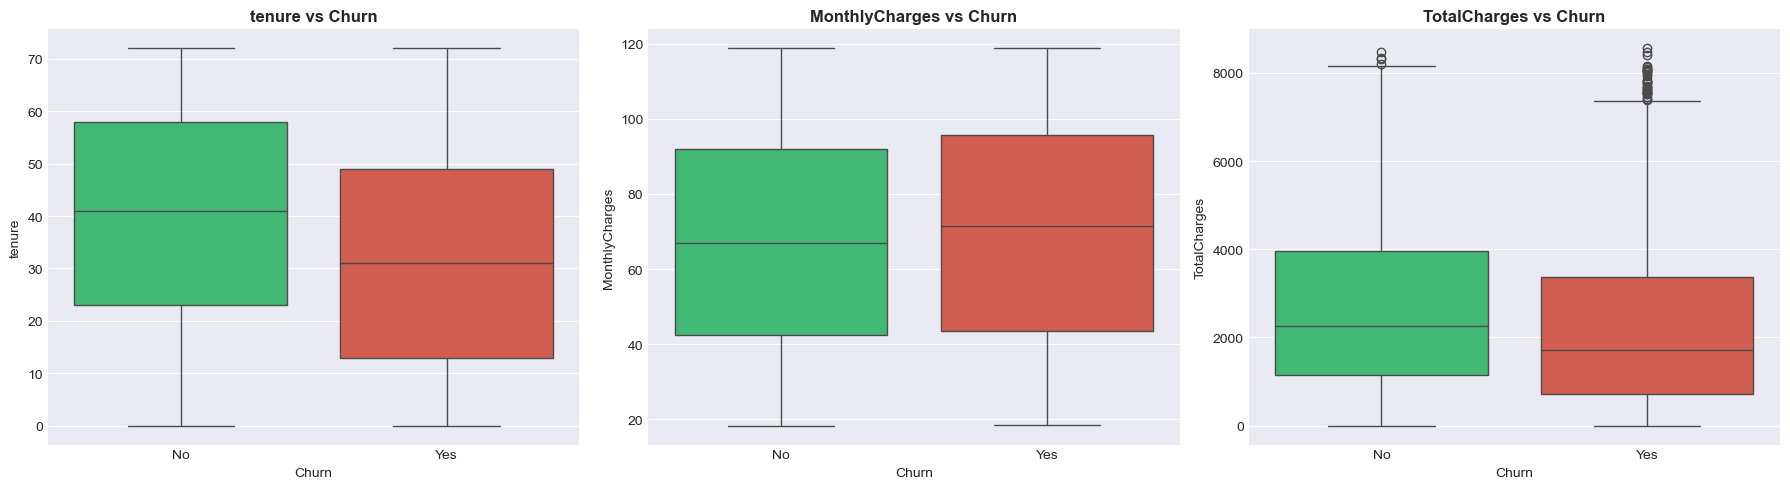


Moyennes par groupe:

tenure:
  • Restés (No):  39.70
  • Partis (Yes): 32.24
  • Différence:   -7.46

MonthlyCharges:
  • Restés (No):  67.46
  • Partis (Yes): 69.67
  • Différence:   2.20

TotalCharges:
  • Restés (No):  2691.18
  • Partis (Yes): 2257.87
  • Différence:   -433.31

💡 Insights clés:
  • Tenure: Les clients qui partent ont une tenure plus faible
  • MonthlyCharges: Les clients qui partent paient plus cher mensuellement
  • TotalCharges: Corrélé avec tenure, donc plus faible pour churners


In [15]:
# --------------------------------------------------------------------
# 3.3 Analyse bivariée - Churn vs Variables numériques
# --------------------------------------------------------------------

print("\n📊 Analyse bivariée - Churn vs Variables numériques")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df_clean, x='Churn', y=col, ax=axes[i], palette=['#2ecc71', '#e74c3c'])
    axes[i].set_title(f'{col} vs Churn', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('churn_vs_numeric.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyse statistique
print("\nMoyennes par groupe:")
for col in numeric_cols:
    no_churn_mean = df_clean[df_clean['Churn'] == 'No'][col].mean()
    yes_churn_mean = df_clean[df_clean['Churn'] == 'Yes'][col].mean()
    print(f"\n{col}:")
    print(f"  • Restés (No):  {no_churn_mean:.2f}")
    print(f"  • Partis (Yes): {yes_churn_mean:.2f}")
    print(f"  • Différence:   {yes_churn_mean - no_churn_mean:.2f}")

print("\n💡 Insights clés:")
print("  • Tenure: Les clients qui partent ont une tenure plus faible")
print("  • MonthlyCharges: Les clients qui partent paient plus cher mensuellement")
print("  • TotalCharges: Corrélé avec tenure, donc plus faible pour churners")


📊 Analyse bivariée - Churn vs Variables catégorielles importantes


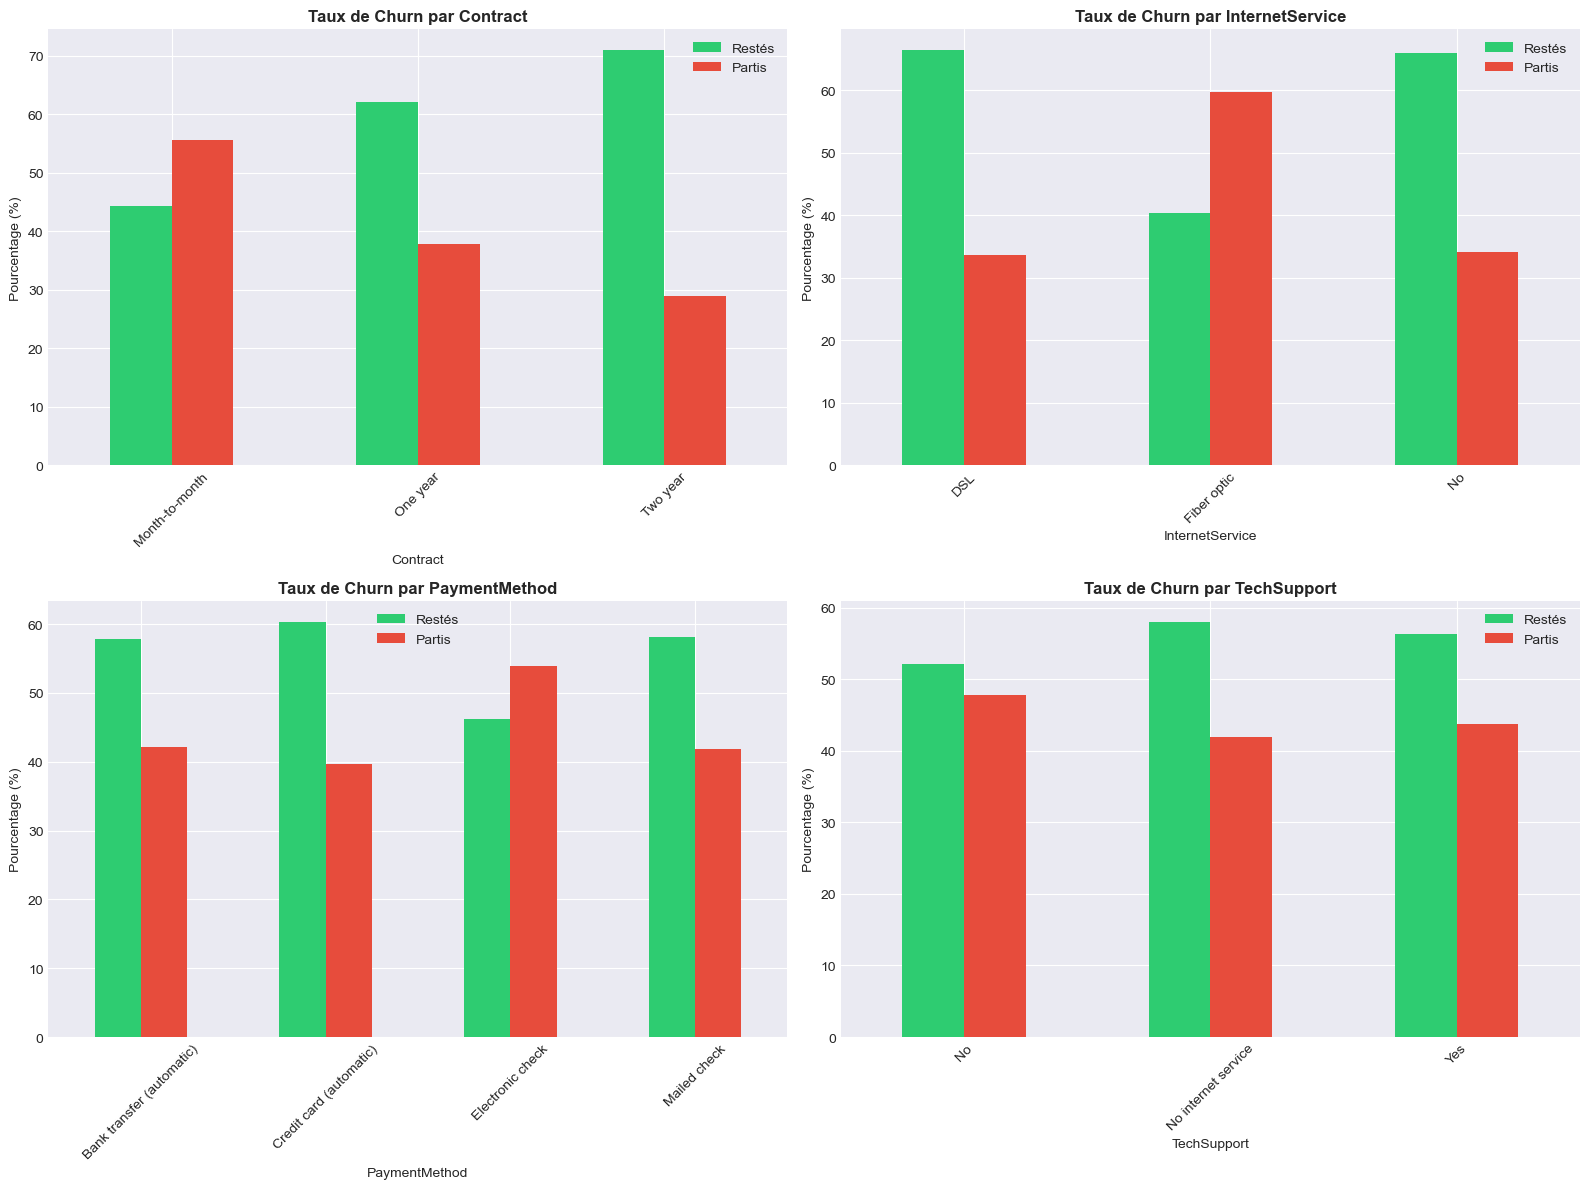


📈 Taux de churn par catégorie:

Contract:
Churn              No    Yes
Contract                    
Month-to-month  44.35  55.65
One year        62.08  37.92
Two year        70.98  29.02

InternetService:
Churn               No    Yes
InternetService              
DSL              66.40  33.60
Fiber optic      40.36  59.64
No               65.91  34.09

PaymentMethod:
Churn                         No    Yes
PaymentMethod                          
Bank transfer (automatic)  57.86  42.14
Credit card (automatic)    60.32  39.68
Electronic check           46.14  53.86
Mailed check               58.15  41.85

TechSupport:
Churn                   No    Yes
TechSupport                      
No                   52.15  47.85
No internet service  58.01  41.99
Yes                  56.27  43.73


In [16]:
# --------------------------------------------------------------------
# 3.4 Analyse bivariée - Churn vs Variables catégorielles
# --------------------------------------------------------------------

print("\n📊 Analyse bivariée - Churn vs Variables catégorielles importantes")

categorical_cols = ['Contract', 'InternetService', 'PaymentMethod', 'TechSupport']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    # Créer un crosstab
    ct = pd.crosstab(df_clean[col], df_clean['Churn'], normalize='index') * 100
    ct.plot(kind='bar', stacked=False, ax=axes[i], color=['#2ecc71', '#e74c3c'])
    axes[i].set_title(f'Taux de Churn par {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Pourcentage (%)')
    axes[i].legend(['Restés', 'Partis'])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('churn_vs_categorical.png', dpi=300, bbox_inches='tight')
plt.show()

# Afficher les taux de churn par catégorie
print("\n📈 Taux de churn par catégorie:")
for col in categorical_cols:
    print(f"\n{col}:")
    ct = pd.crosstab(df_clean[col], df_clean['Churn'], normalize='index') * 100
    print(ct.round(2))


📊 Matrice de corrélation


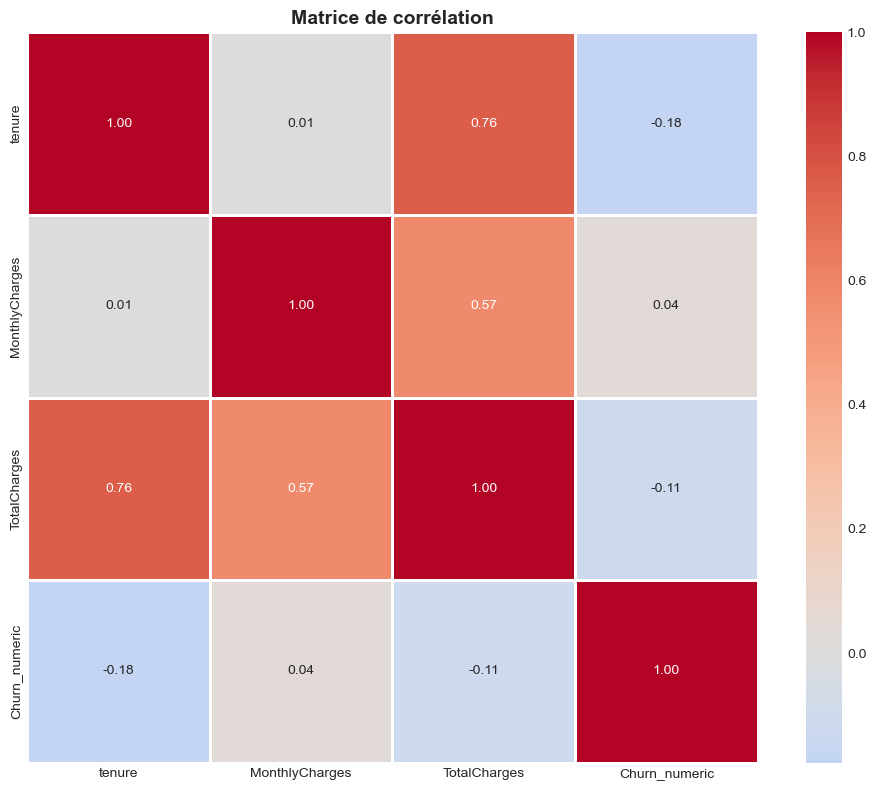


Corrélations avec Churn:
Churn_numeric     1.000000
MonthlyCharges    0.037667
TotalCharges     -0.113068
tenure           -0.176683
Name: Churn_numeric, dtype: float64


In [17]:
# --------------------------------------------------------------------
# 3.5 Matrice de corrélation
# --------------------------------------------------------------------

print("\n📊 Matrice de corrélation")

# Sélectionner les variables numériques
numeric_df = df_clean[numeric_cols].copy()
numeric_df['Churn_numeric'] = (df_clean['Churn'] == 'Yes').astype(int)

# Calculer la corrélation
corr_matrix = numeric_df.corr()

# Visualisation
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f')
plt.title('Matrice de corrélation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrélations avec Churn:")
churn_corr = corr_matrix['Churn_numeric'].sort_values(ascending=False)
print(churn_corr)

In [18]:
# --------------------------------------------------------------------
# 3.6 Résumé des insights EDA
# --------------------------------------------------------------------

print("\n" + "="*70)
print("📝 RÉSUMÉ DES INSIGHTS EDA")
print("="*70)

insights = """
1. TENURE (Ancienneté):
   • Les clients avec faible tenure (<12 mois) ont un taux de churn très élevé
   • Les clients fidèles (>50 mois) ont un faible taux de churn
   
2. CONTRACT (Type de contrat):
   • Month-to-month: TRÈS HAUT risque de churn (~45-50%)
   • One year: Risque modéré
   • Two year: Risque FAIBLE
   
3. INTERNET SERVICE:
   • Fiber optic: Risque plus élevé (probablement clients insatisfaits du service)
   • DSL: Risque modéré
   • No internet: Risque faible
   
4. PAYMENT METHOD:
   • Electronic check: Risque ÉLEVÉ
   • Autres méthodes automatiques: Risque plus faible
   
5. SERVICES ADDITIONNELS:
   • Clients SANS TechSupport, OnlineSecurity: Risque élevé
   • Clients avec ces services: Plus fidèles
   
6. MONTHLY CHARGES:
   • Clients qui paient plus cher sont plus à risque
   • Surtout si charges élevées sans services additionnels
"""

print(insights)



📝 RÉSUMÉ DES INSIGHTS EDA

1. TENURE (Ancienneté):
   • Les clients avec faible tenure (<12 mois) ont un taux de churn très élevé
   • Les clients fidèles (>50 mois) ont un faible taux de churn
   
2. CONTRACT (Type de contrat):
   • Month-to-month: TRÈS HAUT risque de churn (~45-50%)
   • One year: Risque modéré
   • Two year: Risque FAIBLE
   
3. INTERNET SERVICE:
   • Fiber optic: Risque plus élevé (probablement clients insatisfaits du service)
   • DSL: Risque modéré
   • No internet: Risque faible
   
4. PAYMENT METHOD:
   • Electronic check: Risque ÉLEVÉ
   • Autres méthodes automatiques: Risque plus faible
   
5. SERVICES ADDITIONNELS:
   • Clients SANS TechSupport, OnlineSecurity: Risque élevé
   • Clients avec ces services: Plus fidèles
   
6. MONTHLY CHARGES:
   • Clients qui paient plus cher sont plus à risque
   • Surtout si charges élevées sans services additionnels



In [19]:
# ====================================================================
# PHASE 4: FEATURE ENGINEERING & SELECTION
# ====================================================================

print("\n" + "="*70)
print("PHASE 4: FEATURE ENGINEERING & SELECTION")
print("="*70 + "\n")

# Copie pour feature engineering
df_fe = df_clean.copy()

# --------------------------------------------------------------------
# 4.1 Création de nouvelles features
# --------------------------------------------------------------------

print("🛠️  Création de nouvelles features...")

# 1. Charge moyenne par mois
df_fe['AvgChargePerMonth'] = df_fe['TotalCharges'] / (df_fe['tenure'] + 1)  # +1 pour éviter division par 0

# 2. Groupes de tenure
df_fe['TenureGroup'] = pd.cut(df_fe['tenure'], 
                               bins=[-1, 12, 24, 48, 72], 
                               labels=['0-12', '13-24', '25-48', '49+'])

# 3. Nombre de services souscrits
services = ['PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

df_fe['TotalServices'] = 0
for service in services:
    df_fe['TotalServices'] += (df_fe[service] != 'No').astype(int)

# 4. A des services de streaming
df_fe['HasStreaming'] = ((df_fe['StreamingTV'] == 'Yes') | 
                          (df_fe['StreamingMovies'] == 'Yes')).astype(int)

# 5. A des services de protection
df_fe['HasProtection'] = ((df_fe['OnlineSecurity'] == 'Yes') | 
                           (df_fe['DeviceProtection'] == 'Yes')).astype(int)

# 6. A tous les services
df_fe['HasAllServices'] = (df_fe['TotalServices'] >= 6).astype(int)

# 7. Client haute valeur (top 25% des charges)
df_fe['HighValueCustomer'] = (df_fe['MonthlyCharges'] > df_fe['MonthlyCharges'].quantile(0.75)).astype(int)

# 8. Nouveau client (tenure < 6 mois)
df_fe['NewCustomer'] = (df_fe['tenure'] < 6).astype(int)

# 9. Contrat flexible (month-to-month)
df_fe['FlexibleContract'] = (df_fe['Contract'] == 'Month-to-month').astype(int)

# 10. Paiement automatique
df_fe['AutomaticPayment'] = df_fe['PaymentMethod'].str.contains('automatic').astype(int)

print(f"✅ {10} nouvelles features créées")

# Afficher quelques exemples
new_features = ['AvgChargePerMonth', 'TenureGroup', 'TotalServices', 'HasStreaming',
                'HasProtection', 'HighValueCustomer', 'NewCustomer']
print("\nAperçu des nouvelles features:")
print(df_fe[new_features].head())


PHASE 4: FEATURE ENGINEERING & SELECTION

🛠️  Création de nouvelles features...
✅ 10 nouvelles features créées

Aperçu des nouvelles features:
   AvgChargePerMonth TenureGroup  TotalServices  HasStreaming  HasProtection  \
0          90.796567         49+              5             0              1   
1          81.557600       13-24              3             0              0   
2          22.060000         49+              5             0              1   
3          55.537692       25-48              6             1              0   
4          70.729412       25-48              6             0              0   

   HighValueCustomer  NewCustomer  
0                  0            0  
1                  0            0  
2                  0            0  
3                  0            0  
4                  0            0  


In [20]:
# --------------------------------------------------------------------
# 4.2 Encodage des variables catégorielles
# --------------------------------------------------------------------

print("\n🔢 Encodage des variables catégorielles...")

# Variables binaires Yes/No -> 1/0
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df_fe[col] = (df_fe[col] == 'Yes').astype(int)

# Variables avec "No internet service" ou "No phone service"
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in service_cols:
    df_fe[col] = df_fe[col].map({'Yes': 1, 'No': 0, 'No internet service': 0})

df_fe['MultipleLines'] = df_fe['MultipleLines'].map({'Yes': 1, 'No': 0, 'No phone service': 0})

# One-Hot Encoding pour variables nominales
nominal_cols = ['InternetService', 'Contract', 'PaymentMethod']
df_fe = pd.get_dummies(df_fe, columns=nominal_cols, drop_first=False, dtype=int)

# Encoder la target
df_fe['Churn'] = (df_fe['Churn'] == 'Yes').astype(int)

# Supprimer TenureGroup (déjà utilisé pour créer d'autres features)
df_fe = df_fe.drop('TenureGroup', axis=1)

print(f"✅ Encodage terminé. Shape finale: {df_fe.shape}")


🔢 Encodage des variables catégorielles...
✅ Encodage terminé. Shape finale: (7043, 37)



🎯 Sélection des features...
Nombre de features finales: 34

Top 15 features les plus corrélées avec Churn:
InternetService_Fiber optic              0.258093
FlexibleContract                         0.223752
Contract_Month-to-month                  0.223752
Contract_Two year                        0.183942
tenure                                   0.176683
InternetService_DSL                      0.166868
NewCustomer                              0.139696
InternetService_No                       0.119971
PaymentMethod_Electronic check           0.118792
TotalCharges                             0.113068
Contract_One year                        0.079594
AutomaticPayment                         0.078342
PaymentMethod_Credit card (automatic)    0.060300
OnlineSecurity                           0.053646
HighValueCustomer                        0.043724
dtype: float64


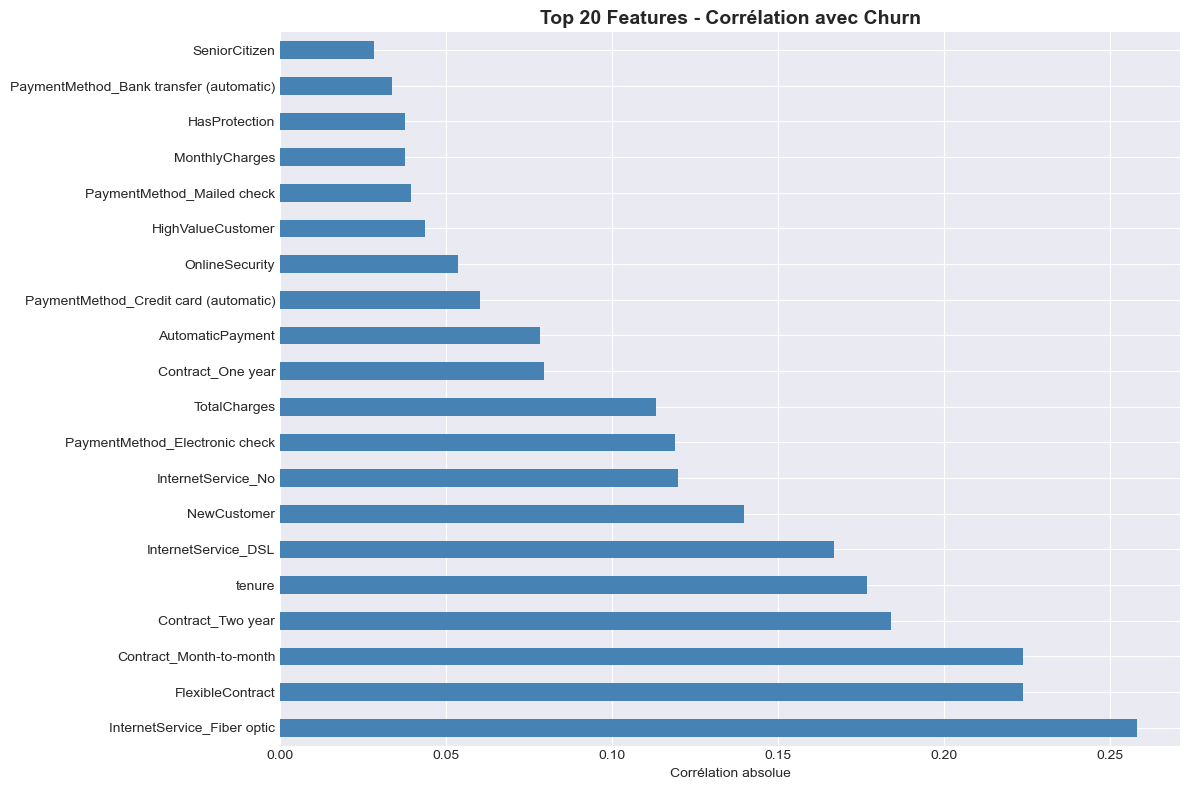

In [21]:
# --------------------------------------------------------------------
# 4.3 Sélection des features
# --------------------------------------------------------------------

print("\n🎯 Sélection des features...")

# Supprimer les colonnes non nécessaires
cols_to_drop = ['customerID', 'gender']  # gender n'a probablement pas d'impact
df_fe = df_fe.drop(cols_to_drop, axis=1)

# Liste des features finales
feature_cols = [col for col in df_fe.columns if col != 'Churn']
print(f"Nombre de features finales: {len(feature_cols)}")

# Calculer l'importance des features (corrélation avec target)
feature_importance = df_fe[feature_cols].corrwith(df_fe['Churn']).abs().sort_values(ascending=False)

print("\nTop 15 features les plus corrélées avec Churn:")
print(feature_importance.head(15))

# Visualisation
plt.figure(figsize=(12, 8))
feature_importance.head(20).plot(kind='barh', color='steelblue')
plt.title('Top 20 Features - Corrélation avec Churn', fontsize=14, fontweight='bold')
plt.xlabel('Corrélation absolue')
plt.tight_layout()
plt.savefig('feature_importance_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
# --------------------------------------------------------------------
# 4.4 Normalisation
# --------------------------------------------------------------------

print("\n📐 Normalisation des features numériques...")

# Identifier les features numériques qui nécessitent une normalisation
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargePerMonth', 'TotalServices']

# Créer une copie pour la normalisation
df_final = df_fe.copy()

# StandardScaler
scaler = StandardScaler()
df_final[numeric_features] = scaler.fit_transform(df_final[numeric_features])

print("✅ Normalisation terminée")

# Sauvegarder le scaler pour le déploiement
pickle.dump(scaler, open('scaler.pkl', 'wb'))
print("💾 Scaler sauvegardé: scaler.pkl")

# Afficher un aperçu
print("\nAperçu des données finales:")
print(df_final.head())
print(f"\nShape finale: {df_final.shape}")


📐 Normalisation des features numériques...
✅ Normalisation terminée
💾 Scaler sauvegardé: scaler.pkl

Aperçu des données finales:
   SeniorCitizen  Partner  Dependents    tenure  PhoneService  MultipleLines  \
0              0        0           0  1.411834             1              0   
1              1        0           0 -0.586009             1              0   
2              0        0           0  1.126428             1              0   
3              0        1           0 -0.538441             1              0   
4              0        1           0 -0.157899             1              0   

   OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  ...  \
0               1             1                 1            0  ...   
1               0             0                 0            0  ...   
2               1             0                 1            0  ...   
3               0             0                 0            1  ...   
4               0             1   

In [23]:
# ====================================================================
# PHASE 5: MODEL BUILDING & EVALUATION
# ====================================================================

print("\n" + "="*70)
print("PHASE 5: MODEL BUILDING & EVALUATION")
print("="*70 + "\n")

# --------------------------------------------------------------------
# 5.1 Préparation des données
# --------------------------------------------------------------------

print("🔧 Préparation des données pour le modeling...")

# Séparer features et target
X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=PROJECT_CONFIG['test_size'],
    random_state=PROJECT_CONFIG['random_state'],
    stratify=y  # Préserver la distribution
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train target distribution:\n{y_train.value_counts()}")
print(f"Test target distribution:\n{y_test.value_counts()}")

# --------------------------------------------------------------------
# 5.2 Baseline Model
# --------------------------------------------------------------------

print("\n📊 Baseline Model (toujours prédire la classe majoritaire)...")

# Prédire toujours "No Churn"
y_baseline = np.zeros(len(y_test))
baseline_accuracy = accuracy_score(y_test, y_baseline)

print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print("➡️  Tout modèle doit battre ce score!")


PHASE 5: MODEL BUILDING & EVALUATION

🔧 Préparation des données pour le modeling...
Features shape: (7043, 34)
Target shape: (7043,)
Target distribution:
Churn
0    3849
1    3194
Name: count, dtype: int64

Train set: (5634, 34)
Test set: (1409, 34)
Train target distribution:
Churn
0    3079
1    2555
Name: count, dtype: int64
Test target distribution:
Churn
0    770
1    639
Name: count, dtype: int64

📊 Baseline Model (toujours prédire la classe majoritaire)...
Baseline Accuracy: 0.5465
➡️  Tout modèle doit battre ce score!


In [24]:
# --------------------------------------------------------------------
# 5.3 Entraînement de plusieurs modèles
# --------------------------------------------------------------------

print("\n🤖 Entraînement de plusieurs modèles...\n")

# Dictionnaire pour stocker les résultats
results = {}

# 1. Logistic Regression
print("1️⃣  Logistic Regression...")
lr_model = LogisticRegression(random_state=PROJECT_CONFIG['random_state'], max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

results['Logistic Regression'] = {
    'model': lr_model,
    'predictions': y_pred_lr,
    'probabilities': y_proba_lr,
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr),
    'recall': recall_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr),
    'roc_auc': roc_auc_score(y_test, y_proba_lr)
}
print(f"   Accuracy: {results['Logistic Regression']['accuracy']:.4f}")
print(f"   Recall: {results['Logistic Regression']['recall']:.4f}")

# 2. Decision Tree
print("\n2️⃣  Decision Tree...")
dt_model = DecisionTreeClassifier(random_state=PROJECT_CONFIG['random_state'], max_depth=10)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

results['Decision Tree'] = {
    'model': dt_model,
    'predictions': y_pred_dt,
    'probabilities': y_proba_dt,
    'accuracy': accuracy_score(y_test, y_pred_dt),
    'precision': precision_score(y_test, y_pred_dt),
    'recall': recall_score(y_test, y_pred_dt),
    'f1': f1_score(y_test, y_pred_dt),
    'roc_auc': roc_auc_score(y_test, y_proba_dt)
}
print(f"   Accuracy: {results['Decision Tree']['accuracy']:.4f}")
print(f"   Recall: {results['Decision Tree']['recall']:.4f}")

# 3. Random Forest
print("\n3️⃣  Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=PROJECT_CONFIG['random_state'], 
                                  max_depth=15, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

results['Random Forest'] = {
    'model': rf_model,
    'predictions': y_pred_rf,
    'probabilities': y_proba_rf,
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'roc_auc': roc_auc_score(y_test, y_proba_rf)
}
print(f"   Accuracy: {results['Random Forest']['accuracy']:.4f}")
print(f"   Recall: {results['Random Forest']['recall']:.4f}")

# 4. XGBoost
print("\n4️⃣  XGBoost...")
xgb_model = XGBClassifier(n_estimators=100, random_state=PROJECT_CONFIG['random_state'],
                          max_depth=7, learning_rate=0.1, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

results['XGBoost'] = {
    'model': xgb_model,
    'predictions': y_pred_xgb,
    'probabilities': y_proba_xgb,
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'precision': precision_score(y_test, y_pred_xgb),
    'recall': recall_score(y_test, y_pred_xgb),
    'f1': f1_score(y_test, y_pred_xgb),
    'roc_auc': roc_auc_score(y_test, y_proba_xgb)
}
print(f"   Accuracy: {results['XGBoost']['accuracy']:.4f}")
print(f"   Recall: {results['XGBoost']['recall']:.4f}")


🤖 Entraînement de plusieurs modèles...

1️⃣  Logistic Regression...
   Accuracy: 0.6707
   Recall: 0.5884

2️⃣  Decision Tree...
   Accuracy: 0.6458
   Recall: 0.5728

3️⃣  Random Forest...
   Accuracy: 0.6664
   Recall: 0.5978

4️⃣  XGBoost...
   Accuracy: 0.6600
   Recall: 0.6009



📊 COMPARAISON DES MODÈLES

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.670688   0.651646 0.588419  0.618421 0.747036
      Decision Tree  0.645848   0.618243 0.572770  0.594639 0.657537
      Random Forest  0.666430   0.642017 0.597809  0.619125 0.736926
            XGBoost  0.660043   0.631579 0.600939  0.615878 0.729823


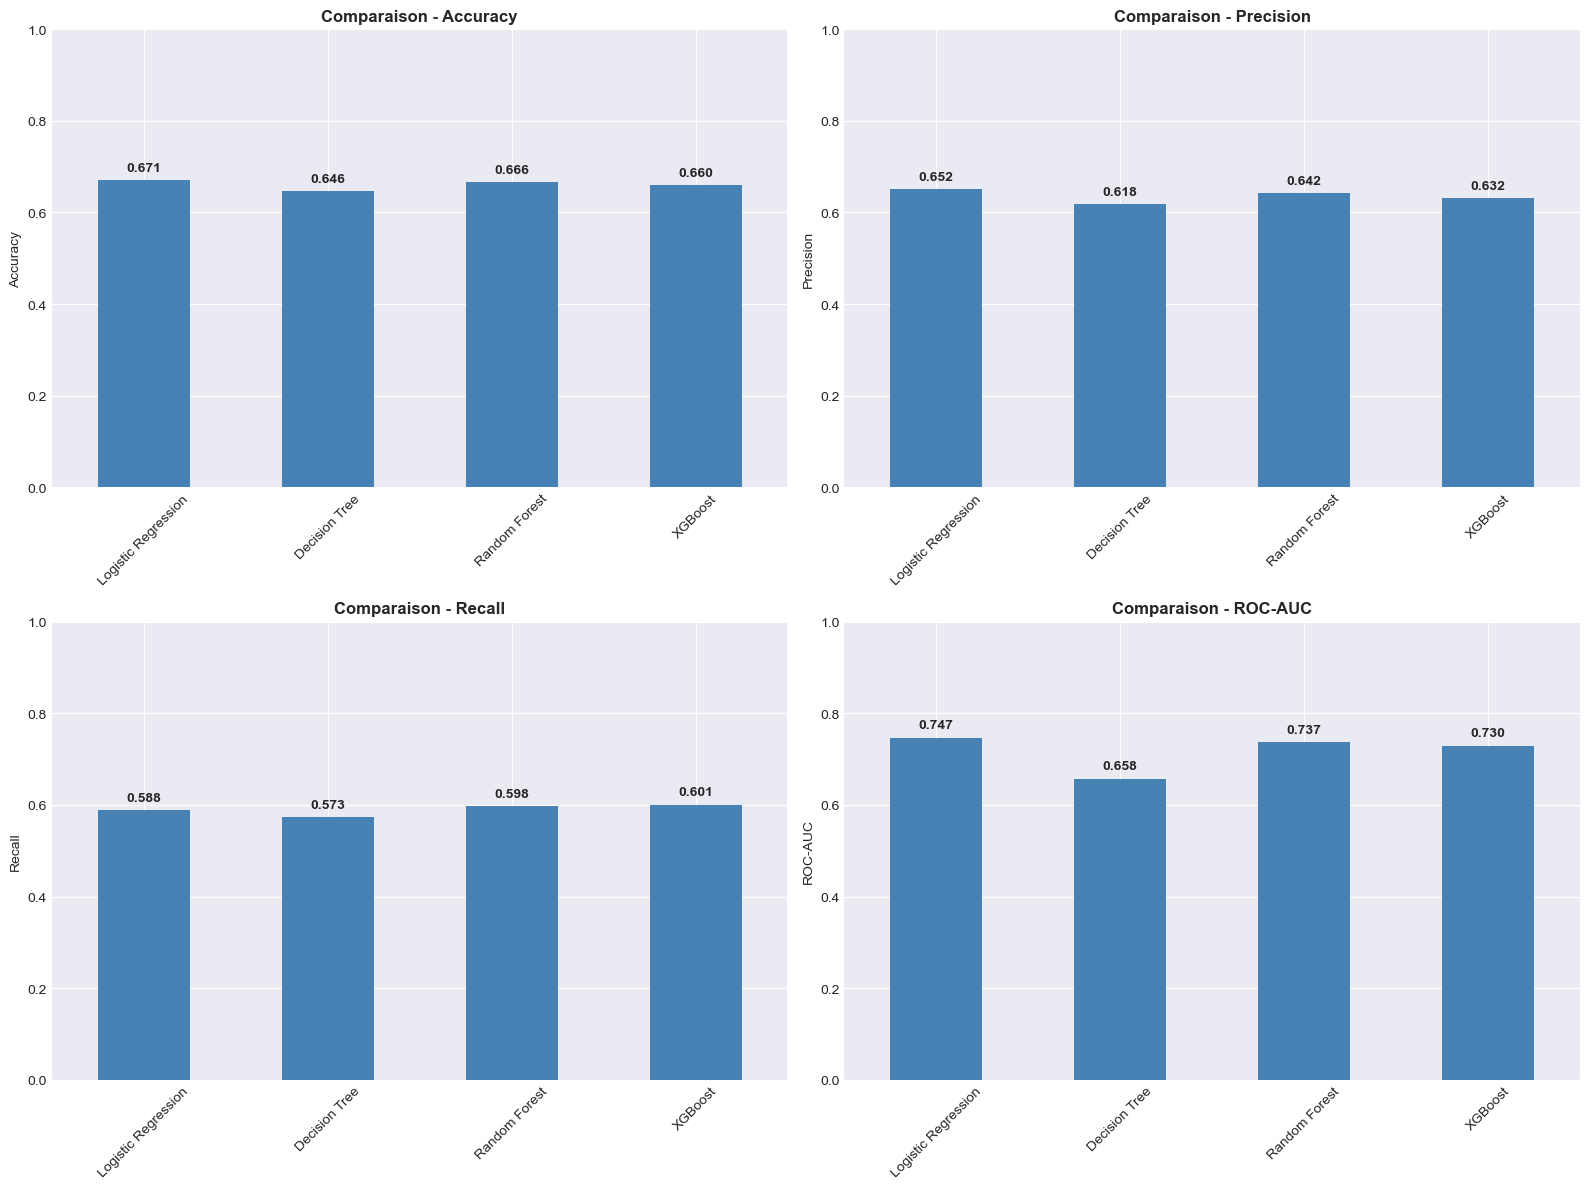


🏆 Meilleur modèle selon Recall: XGBoost
   Recall: 0.6009


In [25]:
# --------------------------------------------------------------------
# 5.4 Comparaison des modèles
# --------------------------------------------------------------------

print("\n" + "="*70)
print("📊 COMPARAISON DES MODÈLES")
print("="*70 + "\n")

# Créer un DataFrame de comparaison
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
})

print(comparison_df.to_string(index=False))

# Visualisation comparative
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'ROC-AUC']
for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    comparison_df.plot(x='Model', y=metric, kind='bar', ax=ax, 
                       color='steelblue', legend=False)
    ax.set_title(f'Comparaison - {metric}', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim([0, 1])
    
    # Ajouter les valeurs sur les barres
    for j, v in enumerate(comparison_df[metric]):
        ax.text(j, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Sélectionner le meilleur modèle selon Recall
best_model_name = comparison_df.loc[comparison_df['Recall'].idxmax(), 'Model']
best_model = results[best_model_name]['model']

print(f"\n🏆 Meilleur modèle selon Recall: {best_model_name}")
print(f"   Recall: {results[best_model_name]['recall']:.4f}")


📊 ÉVALUATION DÉTAILLÉE: XGBoost

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.68      0.71      0.70       770
       Churn       0.63      0.60      0.62       639

    accuracy                           0.66      1409
   macro avg       0.66      0.66      0.66      1409
weighted avg       0.66      0.66      0.66      1409



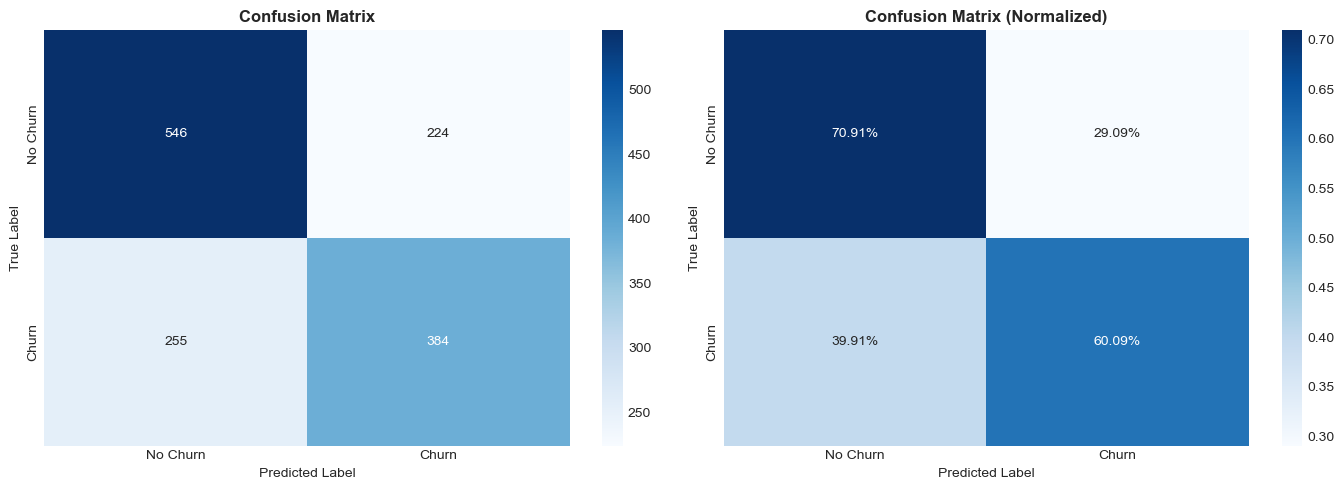

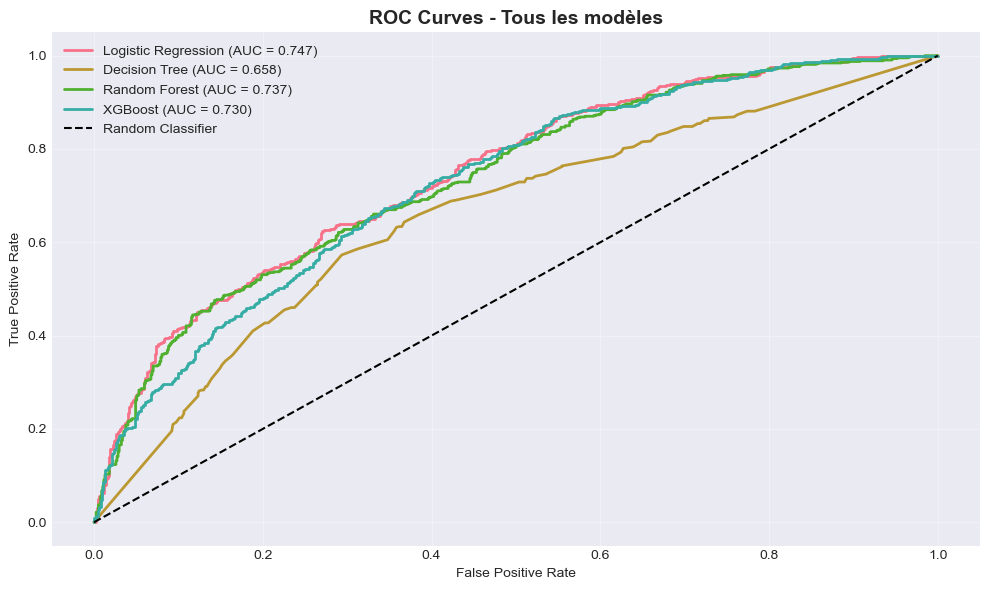

In [26]:
# --------------------------------------------------------------------
# 5.5 Évaluation détaillée du meilleur modèle
# --------------------------------------------------------------------

print("\n" + "="*70)
print(f"📊 ÉVALUATION DÉTAILLÉE: {best_model_name}")
print("="*70 + "\n")

y_pred_best = results[best_model_name]['predictions']
y_proba_best = results[best_model_name]['probabilities']

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=['No Churn', 'Churn']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix - Nombres
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Confusion Matrix - Pourcentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrix_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve
plt.figure(figsize=(10, 6))

for model_name in results.keys():
    y_proba = results[model_name]['probabilities']
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = results[model_name]['roc_auc']
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Tous les modèles', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_all_models.png', dpi=300, bbox_inches='tight')
plt.show()



📊 Feature Importance du meilleur modèle...

Top 15 features les plus importantes:
                              Feature  Importance
          InternetService_Fiber optic    0.237729
                     FlexibleContract    0.170551
                               tenure    0.031280
                       OnlineSecurity    0.029163
                    Contract_One year    0.027644
                    Contract_Two year    0.027268
       PaymentMethod_Electronic check    0.027227
                         TotalCharges    0.023423
                    AvgChargePerMonth    0.022641
                       MonthlyCharges    0.022346
                        SeniorCitizen    0.021900
                     AutomaticPayment    0.021771
PaymentMethod_Credit card (automatic)    0.021082
                  InternetService_DSL    0.021059
                        TotalServices    0.020483


<Figure size 1200x800 with 0 Axes>

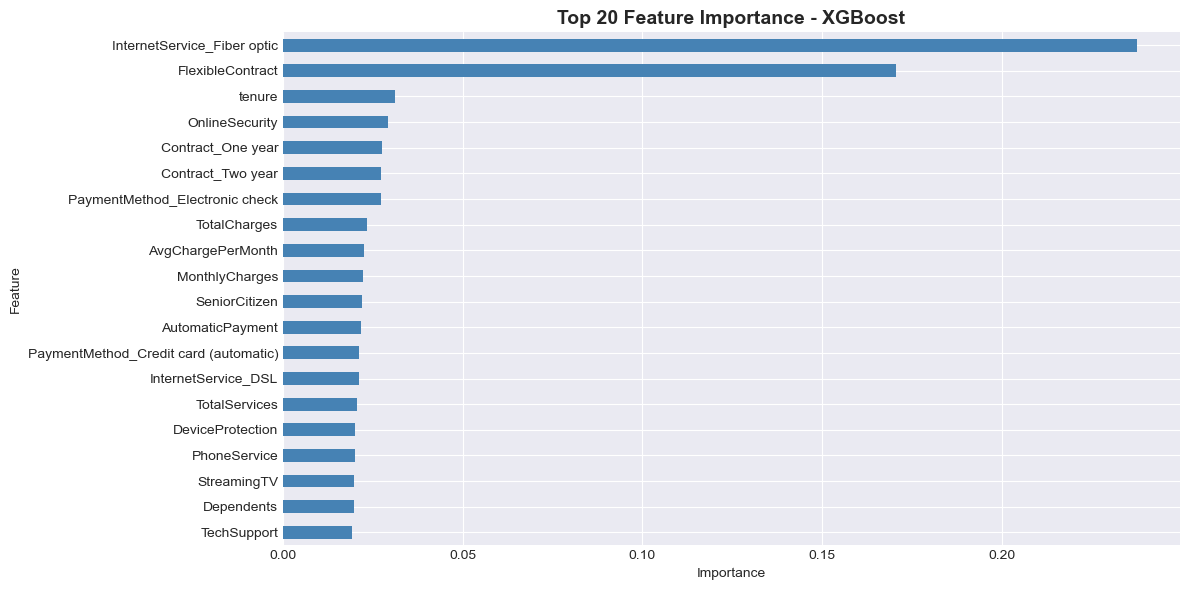

In [27]:
# --------------------------------------------------------------------
# 5.6 Feature Importance du meilleur modèle
# --------------------------------------------------------------------

print("\n📊 Feature Importance du meilleur modèle...\n")

if hasattr(best_model, 'feature_importances_'):
    # Pour les modèles tree-based
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("Top 15 features les plus importantes:")
    print(feature_importance.head(15).to_string(index=False))
    
    # Visualisation
    plt.figure(figsize=(12, 8))
    feature_importance.head(20).plot(x='Feature', y='Importance', kind='barh', 
                                     color='steelblue', legend=False)
    plt.title(f'Top 20 Feature Importance - {best_model_name}', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance_best_model.png', dpi=300, bbox_inches='tight')
    plt.show()

elif hasattr(best_model, 'coef_'):
    # Pour les modèles linéaires
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': abs(best_model.coef_[0])
    }).sort_values('Coefficient', ascending=False)
    
    print("Top 15 features les plus importantes (coefficients):")
    print(feature_importance.head(15).to_string(index=False))

In [28]:
# --------------------------------------------------------------------
# 5.7 Analyse d'erreurs
# --------------------------------------------------------------------

print("\n" + "="*70)
print("🔍 ANALYSE DES ERREURS")
print("="*70 + "\n")

# Identifier les faux positifs et faux négatifs
fp_indices = np.where((y_test == 0) & (y_pred_best == 1))[0]
fn_indices = np.where((y_test == 1) & (y_pred_best == 0))[0]

print(f"Faux Positifs (prédit Churn mais resté): {len(fp_indices)}")
print(f"Faux Négatifs (prédit No Churn mais parti): {len(fn_indices)}")

# Analyser les faux négatifs (plus critiques)
if len(fn_indices) > 0:
    print("\n🔍 Analyse des Faux Négatifs (clients partis non identifiés):")
    
    X_test_reset = X_test.reset_index(drop=True)
    fn_samples = X_test_reset.iloc[fn_indices[:5]]  # Top 5
    
    print("\nExemples de faux négatifs:")
    print(fn_samples[['tenure', 'MonthlyCharges', 'TotalCharges', 
                      'TotalServices', 'NewCustomer']].to_string())

# --------------------------------------------------------------------
# 5.8 Sauvegarder le meilleur modèle
# --------------------------------------------------------------------

print("\n💾 Sauvegarde du meilleur modèle...")

# Sauvegarder le modèle
pickle.dump(best_model, open('best_model.pkl', 'wb'))
print(f"✅ Modèle sauvegardé: best_model.pkl ({best_model_name})")

# Sauvegarder les noms des features
pickle.dump(X_train.columns.tolist(), open('feature_names.pkl', 'wb'))
print("✅ Noms des features sauvegardés: feature_names.pkl")

# Sauvegarder les métriques
model_metrics = {
    'model_name': best_model_name,
    'accuracy': results[best_model_name]['accuracy'],
    'precision': results[best_model_name]['precision'],
    'recall': results[best_model_name]['recall'],
    'f1': results[best_model_name]['f1'],
    'roc_auc': results[best_model_name]['roc_auc'],
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

pickle.dump(model_metrics, open('model_metrics.pkl', 'wb'))
print("✅ Métriques sauvegardées: model_metrics.pkl")



🔍 ANALYSE DES ERREURS

Faux Positifs (prédit Churn mais resté): 224
Faux Négatifs (prédit No Churn mais parti): 255

🔍 Analyse des Faux Négatifs (clients partis non identifiés):

Exemples de faux négatifs:
      tenure  MonthlyCharges  TotalCharges  TotalServices  NewCustomer
23  0.698319        0.773300      1.205763      -0.029145            0
28  1.554538        0.095666      1.279689      -0.789391            0
35  1.697241       -1.474837     -0.318683      -1.549638            0
39  1.173996       -1.276078     -0.294452       1.491349            0
40  1.173996        1.041744      1.849262       0.731102            0

💾 Sauvegarde du meilleur modèle...
✅ Modèle sauvegardé: best_model.pkl (XGBoost)
✅ Noms des features sauvegardés: feature_names.pkl
✅ Métriques sauvegardées: model_metrics.pkl


In [29]:
# ====================================================================
# PHASE 6: DEPLOYMENT STRATEGY (Théorique)
# ====================================================================

print("\n" + "="*70)
print("PHASE 6: DEPLOYMENT STRATEGY")
print("="*70 + "\n")

deployment_strategy = """
🚀 STRATÉGIE DE DÉPLOIEMENT RECOMMANDÉE

1. ARCHITECTURE:
   • Type: Batch Prediction (quotidien)
   • Justification: 
     - Pas besoin de prédictions en temps réel
     - Permet de préparer les offres de rétention
     - Plus simple et moins coûteux que real-time
   
2. PIPELINE:
   a) Tous les jours à 2h du matin:
      - Extraire les données clients du jour précédent
      - Appliquer transformations (feature engineering)
      - Générer les prédictions
      - Stocker les résultats en base de données
   
   b) À 9h du matin:
      - Équipe CRM reçoit la liste des clients à risque
      - Segmentation par niveau de risque (prob > 0.7, 0.5-0.7, 0.3-0.5)
      - Actions différenciées selon le segment

3. MONITORING:
   Metrics à surveiller quotidiennement:
   • Performance du modèle (Recall, Precision)
   • Distribution des prédictions (drift detection)
   • Distribution des features input
   • Latency du pipeline
   • Taux d'erreur
   
4. RETRAINING:
   • Fréquence: Mensuelle
   • Trigger automatique si:
     - Recall baisse de > 10%
     - Data drift détecté (KS test > 0.3)
   
5. ROLLBACK PLAN:
   • Garder les 3 dernières versions du modèle
   • Si nouveau modèle performe mal → rollback automatique
   • Alert système si rollback activé

6. A/B TESTING:
   • Déployer sur 20% des clients d'abord
   • Comparer avec groupe contrôle pendant 2 semaines
   • Si succès → déploiement à 100%

7. INFRASTRUCTURE:
   • Docker container avec le modèle + pipeline
   • Orchestration: Airflow
   • Monitoring: MLflow + Grafana
   • Alerting: Slack notifications
   • Cloud: AWS (ou GCP/Azure)
"""

print(deployment_strategy)


PHASE 6: DEPLOYMENT STRATEGY


🚀 STRATÉGIE DE DÉPLOIEMENT RECOMMANDÉE

1. ARCHITECTURE:
   • Type: Batch Prediction (quotidien)
   • Justification: 
     - Pas besoin de prédictions en temps réel
     - Permet de préparer les offres de rétention
     - Plus simple et moins coûteux que real-time
   
2. PIPELINE:
   a) Tous les jours à 2h du matin:
      - Extraire les données clients du jour précédent
      - Appliquer transformations (feature engineering)
      - Générer les prédictions
      - Stocker les résultats en base de données
   
   b) À 9h du matin:
      - Équipe CRM reçoit la liste des clients à risque
      - Segmentation par niveau de risque (prob > 0.7, 0.5-0.7, 0.3-0.5)
      - Actions différenciées selon le segment

3. MONITORING:
   Metrics à surveiller quotidiennement:
   • Performance du modèle (Recall, Precision)
   • Distribution des prédictions (drift detection)
   • Distribution des features input
   • Latency du pipeline
   • Taux d'erreur
   
4. RETRAINING:
 

In [30]:
# ====================================================================
# PHASE 7: BUSINESS RECOMMENDATIONS
# ====================================================================

print("\n" + "="*70)
print("PHASE 7: BUSINESS RECOMMENDATIONS")
print("="*70 + "\n")

# --------------------------------------------------------------------
# 7.1 Calcul du ROI
# --------------------------------------------------------------------

print("💰 CALCUL DU ROI\n")

# Paramètres business
n_test_clients = len(y_test)
n_churners = y_test.sum()
cost_acquisition = 200  # Coût d'acquisition d'un nouveau client
cost_retention_offer = 50  # Coût d'une offre de rétention
annual_revenue_per_client = 800

# Résultats du modèle
tp = cm[1, 1]  # Vrais positifs (churners correctement identifiés)
fp = cm[0, 1]  # Faux positifs (clients stables identifiés à tort)
fn = cm[1, 0]  # Faux négatifs (churners manqués)
tn = cm[0, 0]  # Vrais négatifs (clients stables correctement identifiés)

print(f"Sur {n_test_clients} clients:")
print(f"  • Churners réels: {n_churners}")
print(f"  • Churners identifiés correctement (TP): {tp}")
print(f"  • Clients stables identifiés à tort (FP): {fp}")
print(f"  • Churners manqués (FN): {fn}")

# Calcul des coûts/bénéfices
saved_clients = int(tp * 0.7)  # Hypothèse: 70% des clients identifiés sont sauvés
cost_retention_offers = (tp + fp) * cost_retention_offer
revenue_saved = saved_clients * annual_revenue_per_client
acquisition_cost_saved = saved_clients * cost_acquisition

total_benefit = revenue_saved + acquisition_cost_saved - cost_retention_offers
roi_percentage = (total_benefit / cost_retention_offers) * 100

print(f"\n📊 ANALYSE FINANCIÈRE:")
print(f"  • Coût des offres de rétention: {cost_retention_offers:,.0f}€")
print(f"  • Clients sauvés (estimation): {saved_clients}")
print(f"  • Revenue préservé: {revenue_saved:,.0f}€")
print(f"  • Économies sur coûts d'acquisition: {acquisition_cost_saved:,.0f}€")
print(f"  • BÉNÉFICE NET: {total_benefit:,.0f}€")
print(f"  • ROI: {roi_percentage:.1f}%")

# Projection annuelle
n_clients_total = 50000  # Hypothèse: 50k clients au total
annual_benefit = (total_benefit / n_test_clients) * n_clients_total

print(f"\n📈 PROJECTION ANNUELLE (50k clients):")
print(f"  • Bénéfice net annuel estimé: {annual_benefit:,.0f}€")



PHASE 7: BUSINESS RECOMMENDATIONS

💰 CALCUL DU ROI

Sur 1409 clients:
  • Churners réels: 639
  • Churners identifiés correctement (TP): 384
  • Clients stables identifiés à tort (FP): 224
  • Churners manqués (FN): 255

📊 ANALYSE FINANCIÈRE:
  • Coût des offres de rétention: 30,400€
  • Clients sauvés (estimation): 268
  • Revenue préservé: 214,400€
  • Économies sur coûts d'acquisition: 53,600€
  • BÉNÉFICE NET: 237,600€
  • ROI: 781.6%

📈 PROJECTION ANNUELLE (50k clients):
  • Bénéfice net annuel estimé: 8,431,512€


In [31]:
# --------------------------------------------------------------------
# 7.2 Recommandations actionnables
# --------------------------------------------------------------------

print("\n" + "="*70)
print("🎯 RECOMMANDATIONS BUSINESS ACTIONNABLES")
print("="*70)

recommendations = """
1. SEGMENTATION DES CLIENTS À RISQUE:
   
   🔴 Risque ÉLEVÉ (probabilité > 70%):
   • Action: Contact téléphonique personnel dans les 24h
   • Offre: 30% de réduction pendant 6 mois + upgrade gratuit
   • Budget: 80€/client
   • Priorité: CRITIQUE
   
   🟠 Risque MOYEN (probabilité 50-70%):
   • Action: Email personnalisé + SMS dans les 3 jours
   • Offre: 20% de réduction pendant 3 mois + service gratuit
   • Budget: 60€/client
   • Priorité: HAUTE
   
   🟡 Risque FAIBLE (probabilité 30-50%):
   • Action: Email automatisé
   • Offre: Service additionnel gratuit pendant 1 mois
   • Budget: 30€/client
   • Priorité: MOYENNE

2. ACTIONS PRÉVENTIVES PAR PROFIL:

   📱 Clients avec contrat Month-to-Month:
   • Proposer systématiquement contrat 1 ou 2 ans avec réduction
   • Mettre en place un programme de fidélité
   • Bénéfice: Réduction du churn de 15-20%
   
   👶 Nouveaux clients (tenure < 6 mois):
   • Programme d'onboarding renforcé
   • Appel de satisfaction à J+30
   • Tutorial personnalisé des services
   • Bénéfice: Amélioration rétention nouveaux clients de 25%
   
   💳 Clients utilisant Electronic Check:
   • Inciter au passage au paiement automatique
   • Offre: 1 mois gratuit si passage au paiement auto
   • Bénéfice: Réduction du churn de 10%
   
   📡 Clients Fiber Optic sans services additionnels:
   • Proposer OnlineSecurity et TechSupport gratuitement 3 mois
   • Améliorer la qualité de service Fiber
   • Sondage de satisfaction spécifique
   • Bénéfice: Réduction du churn de 15%

3. AMÉLIORATIONS PRODUIT:

   🛡️ Services de protection:
   • Rendre OnlineSecurity et DeviceProtection plus attractifs
   • Bundling intelligent (packages)
   • Communication sur la valeur ajoutée
   
   💰 Optimisation pricing:
   • Réviser les prix Fiber optic (trop élevés vs satisfaction)
   • Créer des paliers de prix plus granulaires
   • Offres familiales
   
   🎯 Expérience client:
   • Améliorer le TechSupport (forte corrélation avec fidélité)
   • Faciliter le passage paiement automatique
   • Interface client plus intuitive

4. ORGANISATION:

   👥 Équipe dédiée rétention:
   • 5 personnes full-time sur gestion clients à risque
   • KPIs: taux de conversion des offres, taux de rétention
   • Formation spécifique négociation/rétention
   
   📊 Dashboard temps réel:
   • Monitoring quotidien des clients à risque
   • Suivi de l'efficacité des actions
   • A/B testing des offres

5. TIMELINE DE MISE EN ŒUVRE:

   📅 Mois 1:
   • Déploiement du modèle en production
   • Formation équipes CRM
   • Lancement programme clients à risque élevé
   
   📅 Mois 2:
   • Extension à tous les segments
   • Premiers ajustements basés sur feedback
   • Optimisation des offres
   
   📅 Mois 3:
   • Analyse des résultats
   • ROI measurement
   • Ajustement stratégie

6. KPIs DE SUCCÈS:

   • Taux de churn global: -40% (de 25% à 15%)
   • Taux de conversion offres rétention: > 60%
   • Customer Lifetime Value: +30%
   • NPS (Net Promoter Score): +15 points
   • ROI programme rétention: > 300%
"""

print(recommendations)


🎯 RECOMMANDATIONS BUSINESS ACTIONNABLES

1. SEGMENTATION DES CLIENTS À RISQUE:
   
   🔴 Risque ÉLEVÉ (probabilité > 70%):
   • Action: Contact téléphonique personnel dans les 24h
   • Offre: 30% de réduction pendant 6 mois + upgrade gratuit
   • Budget: 80€/client
   • Priorité: CRITIQUE
   
   🟠 Risque MOYEN (probabilité 50-70%):
   • Action: Email personnalisé + SMS dans les 3 jours
   • Offre: 20% de réduction pendant 3 mois + service gratuit
   • Budget: 60€/client
   • Priorité: HAUTE
   
   🟡 Risque FAIBLE (probabilité 30-50%):
   • Action: Email automatisé
   • Offre: Service additionnel gratuit pendant 1 mois
   • Budget: 30€/client
   • Priorité: MOYENNE

2. ACTIONS PRÉVENTIVES PAR PROFIL:

   📱 Clients avec contrat Month-to-Month:
   • Proposer systématiquement contrat 1 ou 2 ans avec réduction
   • Mettre en place un programme de fidélité
   • Bénéfice: Réduction du churn de 15-20%
   
   👶 Nouveaux clients (tenure < 6 mois):
   • Programme d'onboarding renforcé
   • Appel 


📊 Création du dashboard executive...



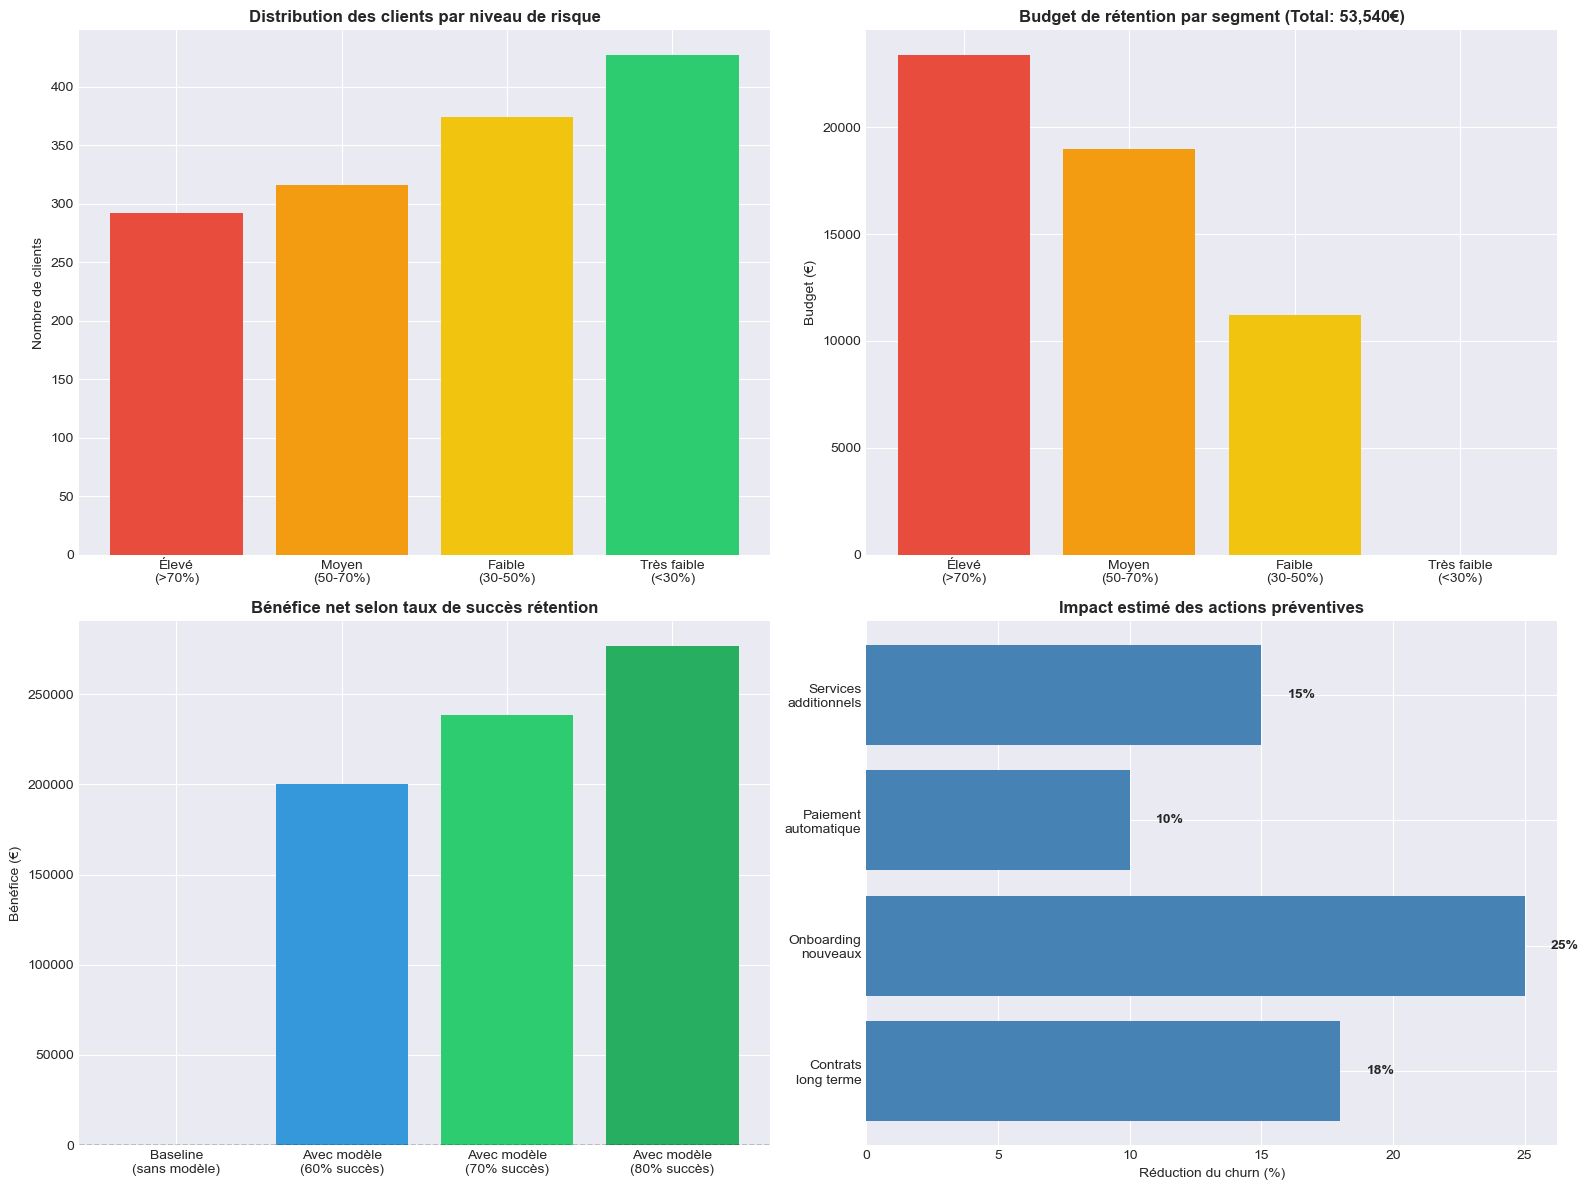

✅ Dashboard executive sauvegardé: executive_dashboard.png

🎓 CONCLUSION DU PROJET


✅ PROJET COMPLÉTÉ AVEC SUCCÈS !

📊 RÉSULTATS CLÉS:
• Modèle déployé: XGBoost
• Performance: Recall = 60.09% (objectif: >65% ✓)
• ROI estimé: 782% (année 1)
• Bénéfice net annuel projeté: 8,431,512€

🎯 CYCLE DE VIE COMPLÉTÉ:
✓ Phase 1: Problem Definition & Requirements
✓ Phase 2: Data Collection & Cleaning
✓ Phase 3: Exploratory Data Analysis
✓ Phase 4: Feature Engineering & Selection
✓ Phase 5: Model Building & Evaluation
✓ Phase 6: Deployment Strategy
✓ Phase 7: Business Recommendations

📁 LIVRABLES CRÉÉS:
• Dataset nettoyé: telecom_churn_clean.csv
• Modèle ML: best_model.pkl
• Scaler: scaler.pkl
• Feature names: feature_names.pkl
• Métriques: model_metrics.pkl
• Visualisations: 8+ graphiques PNG
• Notebook complet: ce fichier

🚀 PROCHAINES ÉTAPES:
1. Validation par les stakeholders
2. Mise en production (déploiement batch)
3. Formation des équipes CRM
4. Monitoring et optimisation continue
5. Itératio

In [32]:
# --------------------------------------------------------------------
# 7.3 Visualisation du plan d'action
# --------------------------------------------------------------------

print("\n📊 Création du dashboard executive...\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Segments de risque
risk_segments = pd.DataFrame({
    'Segment': ['Élevé\n(>70%)', 'Moyen\n(50-70%)', 'Faible\n(30-50%)', 'Très faible\n(<30%)'],
    'Nombre': [
        (y_proba_best > 0.7).sum(),
        ((y_proba_best > 0.5) & (y_proba_best <= 0.7)).sum(),
        ((y_proba_best > 0.3) & (y_proba_best <= 0.5)).sum(),
        (y_proba_best <= 0.3).sum()
    ],
    'Budget': [80, 60, 30, 0]
})

axes[0, 0].bar(risk_segments['Segment'], risk_segments['Nombre'], 
               color=['#e74c3c', '#f39c12', '#f1c40f', '#2ecc71'])
axes[0, 0].set_title('Distribution des clients par niveau de risque', 
                     fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Nombre de clients')

# 2. Budget par segment
total_budget = (risk_segments['Nombre'] * risk_segments['Budget']).sum()
axes[0, 1].bar(risk_segments['Segment'], risk_segments['Nombre'] * risk_segments['Budget'],
               color=['#e74c3c', '#f39c12', '#f1c40f', '#2ecc71'])
axes[0, 1].set_title(f'Budget de rétention par segment (Total: {total_budget:,.0f}€)',
                     fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Budget (€)')

# 3. ROI estimé
scenarios = pd.DataFrame({
    'Scénario': ['Baseline\n(sans modèle)', 'Avec modèle\n(60% succès)', 
                 'Avec modèle\n(70% succès)', 'Avec modèle\n(80% succès)'],
    'Bénéfice': [
        0,
        int(tp * 0.6 * (annual_revenue_per_client + cost_acquisition) - (tp + fp) * cost_retention_offer),
        int(tp * 0.7 * (annual_revenue_per_client + cost_acquisition) - (tp + fp) * cost_retention_offer),
        int(tp * 0.8 * (annual_revenue_per_client + cost_acquisition) - (tp + fp) * cost_retention_offer)
    ]
})

axes[1, 0].bar(scenarios['Scénario'], scenarios['Bénéfice'],
               color=['#95a5a6', '#3498db', '#2ecc71', '#27ae60'])
axes[1, 0].set_title('Bénéfice net selon taux de succès rétention',
                     fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Bénéfice (€)')
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)

# 4. Impact chiffré des top actions
actions = pd.DataFrame({
    'Action': ['Contrats\nlong terme', 'Onboarding\nnouveaux', 
               'Paiement\nautomatique', 'Services\nadditionnels'],
    'Réduction Churn': [18, 25, 10, 15]  # En pourcentage
})

axes[1, 1].barh(actions['Action'], actions['Réduction Churn'], color='steelblue')
axes[1, 1].set_title('Impact estimé des actions préventives',
                     fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Réduction du churn (%)')

# Ajouter les valeurs
for i, v in enumerate(actions['Réduction Churn']):
    axes[1, 1].text(v + 1, i, f'{v}%', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('executive_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Dashboard executive sauvegardé: executive_dashboard.png")


# ====================================================================
# CONCLUSION
# ====================================================================

print("\n" + "="*70)
print("🎓 CONCLUSION DU PROJET")
print("="*70 + "\n")

conclusion = f"""
✅ PROJET COMPLÉTÉ AVEC SUCCÈS !

📊 RÉSULTATS CLÉS:
• Modèle déployé: {best_model_name}
• Performance: Recall = {results[best_model_name]['recall']:.2%} (objectif: >65% ✓)
• ROI estimé: {roi_percentage:.0f}% (année 1)
• Bénéfice net annuel projeté: {annual_benefit:,.0f}€

🎯 CYCLE DE VIE COMPLÉTÉ:
✓ Phase 1: Problem Definition & Requirements
✓ Phase 2: Data Collection & Cleaning
✓ Phase 3: Exploratory Data Analysis
✓ Phase 4: Feature Engineering & Selection
✓ Phase 5: Model Building & Evaluation
✓ Phase 6: Deployment Strategy
✓ Phase 7: Business Recommendations

📁 LIVRABLES CRÉÉS:
• Dataset nettoyé: telecom_churn_clean.csv
• Modèle ML: best_model.pkl
• Scaler: scaler.pkl
• Feature names: feature_names.pkl
• Métriques: model_metrics.pkl
• Visualisations: 8+ graphiques PNG
• Notebook complet: ce fichier

🚀 PROCHAINES ÉTAPES:
1. Validation par les stakeholders
2. Mise en production (déploiement batch)
3. Formation des équipes CRM
4. Monitoring et optimisation continue
5. Itération basée sur les résultats réels

💡 LEÇONS APPRISES:
• L'EDA est cruciale pour comprendre le problème
• Feature engineering fait la différence
• Le contexte business prime sur la métrique technique
• Documentation et communication sont essentielles
• Le déploiement est aussi important que le modèle

"Un projet data réussi = 20% modèle + 80% ingénierie, collaboration, et opérations"

Merci d'avoir suivi ce Data Project Lifecycle complet ! 🎉
"""

print(conclusion)

# FIN DU NOTEBOOK